# Прогнозирование музыкального жанра

**Цель исследования**

Разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

**Задачи:**

- загрузка и ознакомление с данными;
- предварительная обработка;
- EDA;
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков.

**Описание полей данных**
- `instance_id` - уникальный идентификатор трека
- `track_name` - название трека
- `acousticness` - акустичность
- `danceability` - танцевальность
- `duration_ms` -продолжительность в милисекундах
- `energy` - энергичность
- `instrumentalness` - инструментальность
- `key` - базовый ключ (нота) произведения
- `liveness` - привлекательность
- `loudness` - громкость
- `mode` - указывает на модальность (мажорную или минорную) трека
- `speechiness` - выразительность
- `tempo` - темп
- `obtained_date` - дата загрузки в сервис
- `valence` - привлекательность произведения для пользователей сервиса
- `music_genre` - музыкальный жанр

# Импорты

In [197]:
%pip install scikit-learn==1.1.3
%pip install catboost
%pip install imblearn
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [198]:
import pandas as pd
import sweetviz as sv
import seaborn as sb
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import *
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    fbeta_score,
    classification_report
)
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt

In [199]:
train_data = pd.read_csv('./Data/kaggle_music_genre_train.csv')
test_data = pd.read_csv('./Data/kaggle_music_genre_test.csv')

submit_test = pd.read_csv('./Data/sample_submit.csv')

# Обзор данных

Напишем функцию для простого EDA

In [201]:
def info_df(df):
    print('------------------------------')
    print('| Информация о наборе данных |')
    print('------------------------------')
    df.info()
    print('-----------------------------------------')
    print('| Первые и последние 5 строчек датасета |')
    print('-----------------------------------------')
    display(df)
    print('--------------------')
    print('| Сумма дубликатов |')
    print('--------------------')
    print(df.duplicated().sum())
    print('---------------------------')
    print('| Описательная статистика |')
    print('---------------------------')
    display(df.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn'))
    print('--------------------------')
    print('| Ковариационная матрица |')
    print('--------------------------')
    plt.figure(figsize=(15, 13))
    sb.heatmap(df.corr(), annot=True, cmap=sb.diverging_palette(220, 10, as_cmap=True));
    plt.show()

Рассмотрим загруженные датасеты

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.48000,0.670,182653.0,0.351,0.017600,D,0.1150,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.24300,0.452,187133.0,0.670,0.000051,A,0.1080,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.22800,0.454,173448.0,0.804,0.000000,E,0.1810,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.05580,0.847,255987.0,0.873,0.000003,G#,0.3250,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.22700,0.742,195333.0,0.575,0.000002,C,0.1760,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20389,47396.0,O Pato,0.71900,0.725,-1.0,0.483,0.000000,NaN,0.0797,-13.314,Minor,0.0438,87.413,4-Apr,0.942,Jazz
20390,44799.0,Mt. Washington,0.19000,0.482,198933.0,0.362,0.005620,F#,0.0913,-10.358,Minor,0.0299,76.879,4-Apr,0.174,Rock
20391,33350.0,Original Prankster,0.00061,0.663,220947.0,0.886,0.000025,D,0.2840,-4.149,Major,0.0358,146.803,4-Apr,0.942,Alternative
20392,77920.0,4Peat,0.00310,0.914,162214.0,0.515,0.000000,C#,0.1050,-9.934,Major,0.3560,150.016,4-Apr,0.215,Rap


--------------------
| Сумма дубликатов |
--------------------
0
---------------------------
| Описательная статистика |
---------------------------


,count,mean,std,min,25%,50%,75%,max
instance_id,20394.000000,55973.846916,20695.792545,20011.000000,38157.250000,56030.000000,73912.750000,91758.000000
acousticness,20394.000000,0.274783,0.321643,0.000000,0.015200,0.120000,0.470000,0.996000
danceability,20394.000000,0.561983,0.171898,0.060000,0.451000,0.570000,0.683000,0.978000
duration_ms,20394.000000,220375.425272,126728.326142,-1.000000,177517.000000,219533.000000,266000.000000,4497994.000000
energy,20394.000000,0.625276,0.251238,0.001010,0.470000,0.666000,0.830000,0.999000
instrumentalness,20394.000000,0.159989,0.306503,0.000000,0.000000,0.000144,0.084475,0.996000
liveness,20394.000000,0.198540,0.166742,0.013600,0.097300,0.130000,0.253000,1.000000
loudness,20394.000000,-8.552998,5.499917,-44.406000,-10.255750,-7.052000,-5.054000,3.744000
speechiness,20394.000000,0.091352,0.097735,0.022300,0.035600,0.049050,0.095575,0.942000
tempo,19952.000000,120.942522,30.427590,34.765000,95.921750,120.012500,141.966250,220.041000


--------------------------
| Ковариационная матрица |
--------------------------


/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_3926/2087626265.py:25: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), annot=True, cmap=sb.diverging_palette(220, 10, as_cmap=True));


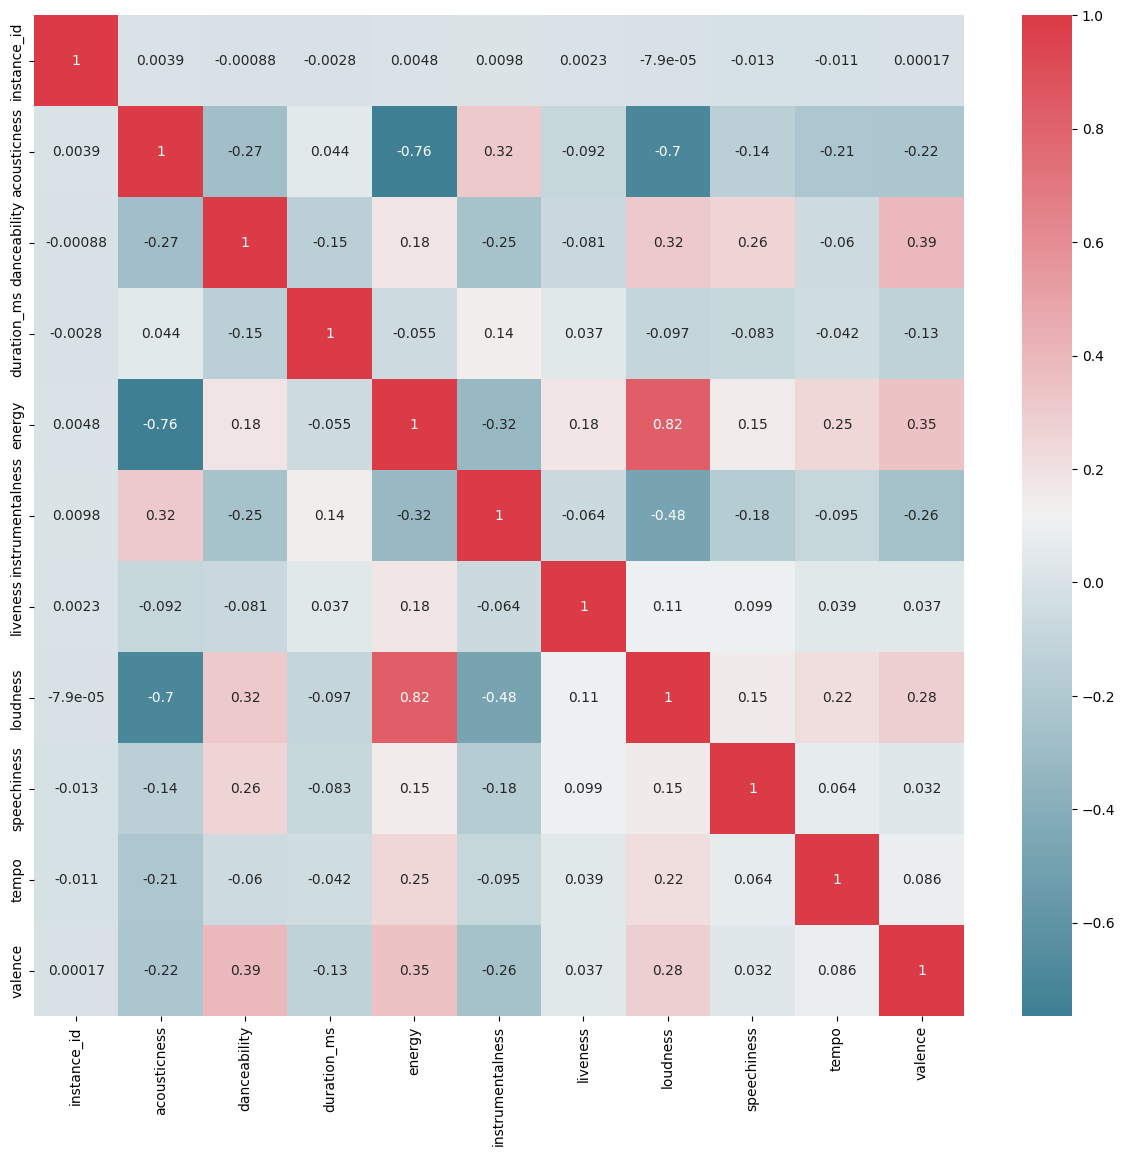

In [202]:
info_df(train_data)

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
d

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5094,50532,What We Gonna Do About It,0.108000,0.558,163049.0,0.767,0.00000,E,0.0954,-4.561,Minor,0.0491,158.019,4-Apr,0.715
5095,26255,Marilyn (feat. Dominique Le Jeune),0.131000,0.435,196216.0,0.641,0.00000,A#,0.2730,-7.274,Major,0.1040,115.534,3-Apr,0.156
5096,67924,Bipolar,0.152000,0.756,243373.0,0.787,0.00000,D,0.2050,-7.423,Major,0.2400,123.405,4-Apr,0.459
5097,79778,Dead - NGHTMRE Remix,0.001450,0.489,185600.0,0.974,0.63800,F#,0.1230,-2.857,Minor,0.0381,150.036,4-Apr,0.665


--------------------
| Сумма дубликатов |
--------------------
0
---------------------------
| Описательная статистика |
---------------------------


,count,mean,std,min,25%,50%,75%,max
instance_id,5099.000000,55643.871347,20762.384803,20012.000000,37571.000000,55246.000000,73702.000000,91709.000000
acousticness,5099.000000,0.276324,0.322657,0.000002,0.016600,0.120000,0.460000,0.996000
danceability,5099.000000,0.561888,0.170502,0.059600,0.451000,0.568000,0.681000,0.977000
duration_ms,5099.000000,217397.407727,115637.408282,-1.000000,173733.500000,217500.000000,264247.000000,1360027.000000
energy,5099.000000,0.622030,0.251829,0.001540,0.465000,0.660000,0.826000,0.999000
instrumentalness,5099.000000,0.165198,0.311940,0.000000,0.000000,0.000157,0.092750,0.994000
liveness,5099.000000,0.197924,0.166241,0.020400,0.096950,0.129000,0.248000,0.990000
loudness,5099.000000,-8.630186,5.619766,-46.122000,-10.231000,-7.135000,-5.127000,1.949000
speechiness,5099.000000,0.092718,0.100130,0.022600,0.035700,0.048700,0.096550,0.918000
tempo,4978.000000,121.246463,29.875950,37.114000,96.070250,120.053500,141.934250,216.029000


--------------------------
| Ковариационная матрица |
--------------------------


/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_3926/2087626265.py:25: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), annot=True, cmap=sb.diverging_palette(220, 10, as_cmap=True));


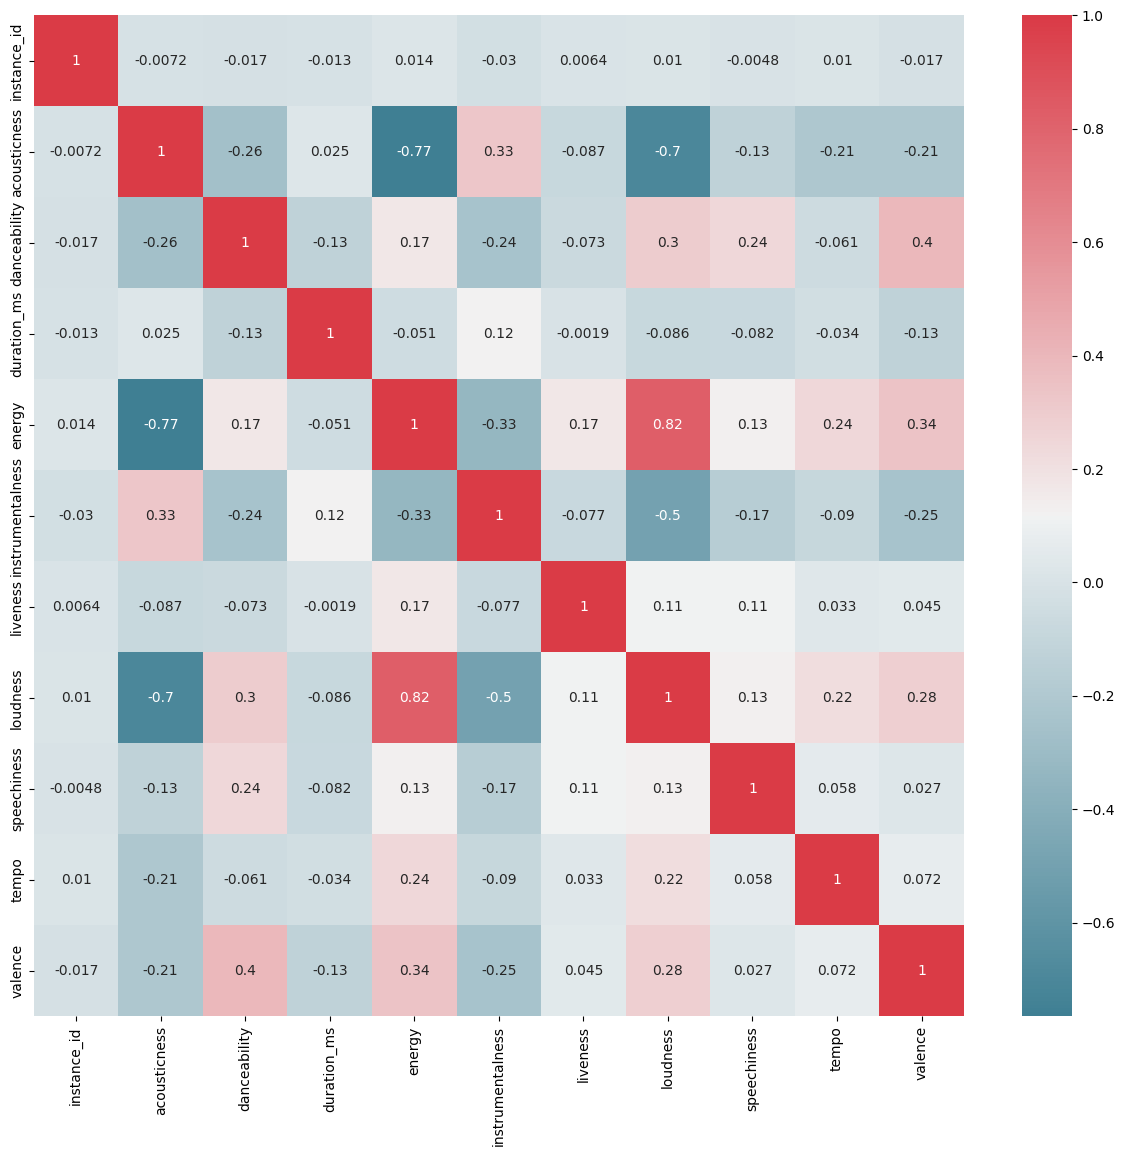

In [203]:
info_df(test_data)

Сразу можно отметить наличие высокой прямой и обратной корреляции Пирсона для некоторых параметров, таких как: акустичность, энергичность и громкость. Чуть позже будет рассмотрена корреляция Спирмена, предполагая что параметры линеной не связаны. 

Посмотрим на соотношение пропусков данных

In [204]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
instance_id,0.000000
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.600000
liveness,0.000000
loudness,0.000000


In [205]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
pd.DataFrame(round(test_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
instance_id,0.000000
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.100000
liveness,0.000000
loudness,0.000000


Оба набора данных имеют пропски, обработаем их ниже.

# Константы

In [206]:
RANDOM_STATE = 1220

# Дополнительная информация из сторонних датасетов

Предполагая, что данных в исходном датасете будет не достаточно для решения задачи мультиклассификации, было принято решение найти дополнительную информацию на сайте Kaggle (https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre?datasetId=1690118&sortBy=voteCount&select=music_genre.csv)

In [207]:
train_data_2 = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Music_genre_classification/Data/music_genre.csv')

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,58878.0,BEXEY,GO GETTA,59.0,0.03340,0.913,-1.0,0.574,0.00000,C#,0.119,-7.022,Major,0.2980,98.02799999999999,4-Apr,0.330,Hip-Hop
50001,43557.0,Roy Woods,Drama (feat. Drake),72.0,0.15700,0.709,251860.0,0.362,0.00000,B,0.109,-9.814,Major,0.0550,122.04299999999999,4-Apr,0.113,Hip-Hop
50002,39767.0,Berner,Lovin' Me (feat. Smiggz),51.0,0.00597,0.693,189483.0,0.763,0.00000,D,0.143,-5.443,Major,0.1460,131.079,4-Apr,0.395,Hip-Hop
50003,57944.0,The-Dream,Shawty Is Da Shit,65.0,0.08310,0.782,262773.0,0.472,0.00000,G,0.106,-5.016,Minor,0.0441,75.88600000000001,4-Apr,0.354,Hip-Hop


--------------------
| Сумма дубликатов |
--------------------
4
---------------------------
| Описательная статистика |
---------------------------


,count,mean,std,min,25%,50%,75%,max
instance_id,50000.000000,55888.396360,20725.256253,20002.000000,37973.500000,55913.500000,73863.250000,91759.000000
popularity,50000.000000,44.220420,15.542008,0.000000,34.000000,45.000000,56.000000,99.000000
acousticness,50000.000000,0.306383,0.341340,0.000000,0.020000,0.144000,0.552000,0.996000
danceability,50000.000000,0.558241,0.178632,0.059600,0.442000,0.568000,0.687000,0.986000
duration_ms,50000.000000,221252.602860,128671.957157,-1.000000,174800.000000,219281.000000,268612.250000,4830606.000000
energy,50000.000000,0.599755,0.264559,0.000792,0.433000,0.643000,0.815000,0.999000
instrumentalness,50000.000000,0.181601,0.325409,0.000000,0.000000,0.000158,0.155000,0.996000
liveness,50000.000000,0.193896,0.161637,0.009670,0.096900,0.126000,0.244000,1.000000
loudness,50000.000000,-9.133761,6.162990,-47.046000,-10.860000,-7.276500,-5.173000,3.744000
speechiness,50000.000000,0.093586,0.101373,0.022300,0.036100,0.048900,0.098525,0.942000


--------------------------
| Ковариационная матрица |
--------------------------


/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_3926/2087626265.py:25: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), annot=True, cmap=sb.diverging_palette(220, 10, as_cmap=True));


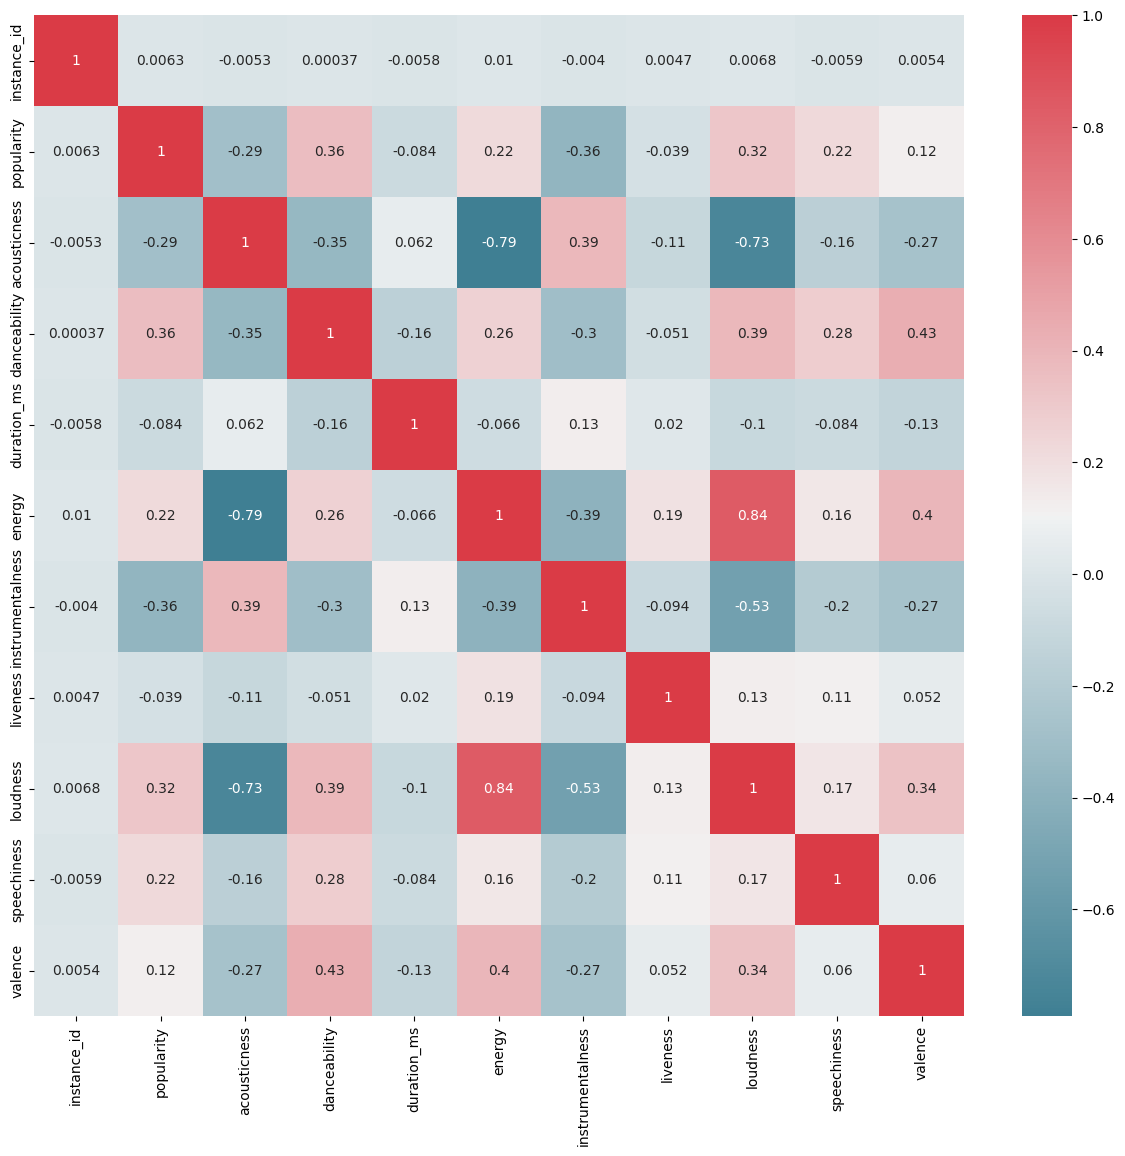

In [209]:
info_df(train_data_2)

Подготовим два набора данных для слияния убрав дополнительный параметр Популярность, так как в нашем исходном датасете нет такой информации. Также избавимся от идентификатора, названия трека и даты загрузки трека на платформу, так как они не помогут нам в обучении модели

In [210]:
train_data = train_data.drop(['instance_id', 'obtained_date', 'track_name'], axis=1)

In [211]:
train_data_2 = train_data_2.drop(['artist_name', 'instance_id', 'obtained_date', 'popularity', 'track_name'], axis=1)

In [212]:
train_data.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,0.450,Country
1,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,0.539,Rock
2,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,0.344,Alternative
3,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,0.966,Hip-Hop
4,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,0.583,Alternative


In [213]:
train_data_2.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,0.759,Electronic
1,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,0.531,Electronic
2,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,0.333,Electronic
3,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,0.270,Electronic
4,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,0.323,Electronic


In [214]:
train_data = pd.concat([train_data, train_data_2])

In [215]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,1.100000
liveness,0.000000
loudness,0.000000
mode,0.700000
speechiness,0.000000


С увеличением выборки отношение пропусков изменилось, посмотрим на количество пропусков.

In [216]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70399 entries, 0 to 50004
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      70394 non-null  float64
 1   danceability      70394 non-null  float64
 2   duration_ms       70394 non-null  float64
 3   energy            70394 non-null  float64
 4   instrumentalness  70394 non-null  float64
 5   key               69659 non-null  object 
 6   liveness          70394 non-null  float64
 7   loudness          70394 non-null  float64
 8   mode              69888 non-null  object 
 9   speechiness       70394 non-null  float64
 10  tempo             69952 non-null  object 
 11  valence           70394 non-null  float64
 12  music_genre       70394 non-null  object 
dtypes: float64(9), object(4)
memory usage: 7.5+ MB


# Предобработка и исследовательский анализ данных (EDA)

## Пропуски в данных

Разберем каждый признак в котором имеются пропуски и выполним заполнение этих пропусков.

**Key - Mode**

Для заполненения пропусков в признаках нота и модальность принято решение о замене на значение `N`, после чего преобразуем данные в числовые признаки для более удобной классификации.

In [217]:
train_data['key'] = train_data['key'].fillna('N')
train_data['mode'] = train_data['mode'].fillna('N')

test_data['key'] = test_data['key'].fillna('N')
test_data['mode'] = test_data['mode'].fillna('N')

In [218]:
mode_dict = {'Major' : 1, 'Minor' : 0, 'N': -1}
key_dict = {'N': -1,'C' : 1, 'C#' : 2, 'D' : 3, 'D#' : 4, 'E' : 5, 'F' : 6, 
        'F#' : 7, 'G' : 9, 'G#' : 10, 'A' : 11, 'A#' : 12, 'B' : 13}

train_data['mode'].replace(mode_dict, inplace=True)
train_data['key'] = train_data['key'].replace(key_dict).astype(int)
test_data['mode'].replace(mode_dict, inplace=True)
test_data['key'] = test_data['key'].replace(key_dict).astype(int)

**Tempo**

Для признака Темп выполним заполнение пропусков медианным значением для каждого жанра.

In [219]:
train_data.loc[train_data['tempo'].isna() == True]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
63,0.287000,0.476,212427.0,0.612,0.000252,11,0.0877,-7.010,1,0.0335,NaN,0.909,Rock
85,0.000059,0.489,269000.0,0.947,0.000000,2,0.1130,-3.925,0,0.0419,NaN,0.517,Anime
114,0.348000,0.698,362267.0,0.800,0.000087,13,0.4430,-3.091,0,0.0284,NaN,0.654,Blues
138,0.008340,0.776,191210.0,0.783,0.044900,1,0.0377,-3.595,1,0.0374,NaN,0.943,Electronic
145,0.001100,0.608,178440.0,0.801,0.000008,11,0.2230,-5.452,0,0.0376,NaN,0.544,Alternative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10000,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN


In [220]:
test_data.loc[test_data['tempo'].isna() == True]

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
101,79753,She Walks In Beauty,0.981000,0.174,287360.0,0.0289,0.829000,9,0.0817,-25.038,1,0.0391,NaN,3-Apr,0.0315
131,27331,Tell Me Why,0.098400,0.611,142013.0,0.4490,0.000000,3,0.2260,-8.938,0,0.2940,NaN,4-Apr,0.2240
172,34855,Like You,0.383000,0.616,184033.0,0.4090,0.000000,2,0.1400,-8.427,1,0.2980,NaN,4-Apr,0.4530
212,43840,Matador (feat. Thompson Square),0.003600,0.528,241293.0,0.8250,0.000002,13,0.3690,-4.740,0,0.0602,NaN,4-Apr,0.4090
343,79286,New Fang,0.000010,0.276,228640.0,0.9620,0.000366,13,0.0327,-3.797,0,0.0629,NaN,4-Apr,0.7410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4918,50651,8 Bit Superhero,0.000346,0.377,296250.0,0.9200,0.903000,7,0.1950,-3.233,0,0.0529,NaN,4-Apr,0.1410
4923,89536,Whatcha Gonna Do With A Cowboy,0.342000,0.723,154000.0,0.8110,0.000000,11,0.0960,-4.147,1,0.1080,NaN,4-Apr,0.9210
4986,83279,First World Problemz / Nobody Carez,0.259000,0.582,350549.0,0.5020,0.000378,4,0.1600,-11.053,0,0.1020,NaN,4-Apr,0.5550
5076,54490,Deliver Me,0.000078,0.290,253839.0,0.8680,0.000005,2,0.4080,-4.392,1,0.0773,NaN,4-Apr,0.1930


При обзоре данных был найден артефакт в записи Темпа в виде символа `?`

In [221]:
train_data[train_data['tempo'] == '?']

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
5,0.00523,0.755,519468.0,0.731,0.854000,3,0.2160,-10.517,0,0.0412,?,0.6140,Electronic
32,0.02330,0.729,274286.0,0.869,0.585000,6,0.0944,-7.569,0,0.1290,?,0.1380,Electronic
35,0.10800,0.493,-1.0,0.682,0.000000,11,0.1960,-5.781,0,0.2870,?,0.2390,Electronic
36,0.04780,0.646,253333.0,0.649,0.002520,9,0.3530,-5.259,1,0.1170,?,0.7270,Electronic
39,0.20300,0.769,429941.0,0.551,0.882000,12,0.1090,-12.520,0,0.0408,?,0.0618,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49918,0.29600,0.379,292520.0,0.644,0.000000,12,0.3130,-7.933,0,0.1120,?,0.1440,Hip-Hop
49964,0.08470,0.929,215200.0,0.737,0.000000,10,0.8610,-6.424,1,0.1020,?,0.8860,Hip-Hop
49967,0.17900,0.860,233293.0,0.625,0.000136,3,0.3000,-6.922,1,0.1050,?,0.2210,Hip-Hop
49976,0.70000,0.462,225067.0,0.741,0.000000,12,0.3400,-8.008,0,0.1620,?,0.5890,Hip-Hop


In [222]:
test_data[test_data['tempo'] == '?']

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence


In [223]:
for genre in train_data['music_genre'].unique():
    train_data.loc[(train_data['music_genre'] == genre) 
                   & (train_data['tempo'] == '?') 
                   | (train_data['tempo'].isna() == True),
                   'tempo'] = \
    train_data.loc[(train_data['music_genre'] == genre)
                   & (train_data['tempo'] != '?'),
                     'tempo'].median()

In [224]:
test_data.loc[test_data['tempo'].isna() == True,'tempo'] = 0

In [225]:
train_data['tempo'] = train_data['tempo'].astype('float32')

In [226]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,0.000000
liveness,0.000000
loudness,0.000000
mode,0.000000
speechiness,0.000000


### Явные дубликаты

In [227]:
train_data.duplicated().sum()

18792

In [228]:
train_data = train_data.drop_duplicates().reset_index(drop=True)

#### Поиск аномальных значений

Обратим внимание на длительность некоторых треков в -1 миллисекунду. Вариантов несколько: можно удалить все треки которые имеют такое значение и потерять кусочек данных, можно заменить медианным значением всех треков, а можно сентезировать новый признак в который бы делил треки на короткие, длинные и средние.

In [229]:
train_data['duration_ms'].describe()

count    5.160600e+04
mean     2.210772e+05
std      1.284283e+05
min     -1.000000e+00
25%      1.748140e+05
50%      2.192130e+05
75%      2.684098e+05
max      4.830606e+06
Name: duration_ms, dtype: float64

In [230]:
train_data.loc[train_data['duration_ms'] == -1]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
13,0.1100,0.470,-1.0,0.6410,0.000000,7,0.1550,-7.454,1,0.0658,86.387001,0.6380,Anime
26,0.9910,0.154,-1.0,0.0384,0.902000,-1,0.1090,-26.909,1,0.0405,68.198997,0.0393,Classical
35,0.0848,0.748,-1.0,0.7120,0.000000,3,0.1320,-5.651,1,0.1430,140.054993,0.1800,Rap
50,0.0540,0.482,-1.0,0.6270,0.000003,3,0.1110,-5.779,1,0.0300,95.903000,0.1700,Alternative
55,0.9090,0.374,-1.0,0.2270,0.000069,12,0.6860,-18.719,1,0.0579,78.236000,0.2640,Classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51567,0.1330,0.867,-1.0,0.6180,0.000002,13,0.1280,-4.956,0,0.0614,140.005005,0.8570,Hip-Hop
51577,0.0127,0.706,-1.0,0.7870,0.000000,11,0.2650,-5.314,1,0.0888,85.962997,0.2430,Hip-Hop
51585,0.4830,0.789,-1.0,0.4520,0.000000,13,0.0892,-7.538,0,0.4800,140.100998,0.2840,Hip-Hop
51586,0.0635,0.594,-1.0,0.8230,0.000000,11,0.0950,-5.210,1,0.3320,97.100998,0.6630,Hip-Hop


Треки в которых значение длительности равно -1 менее 10%, предполагая, что мы будем избавляться от этого признака оставим данные как есть, дабы не потерять другие важные признаки.

**Длительность трека**

Оценим экстремумы треков в датасете

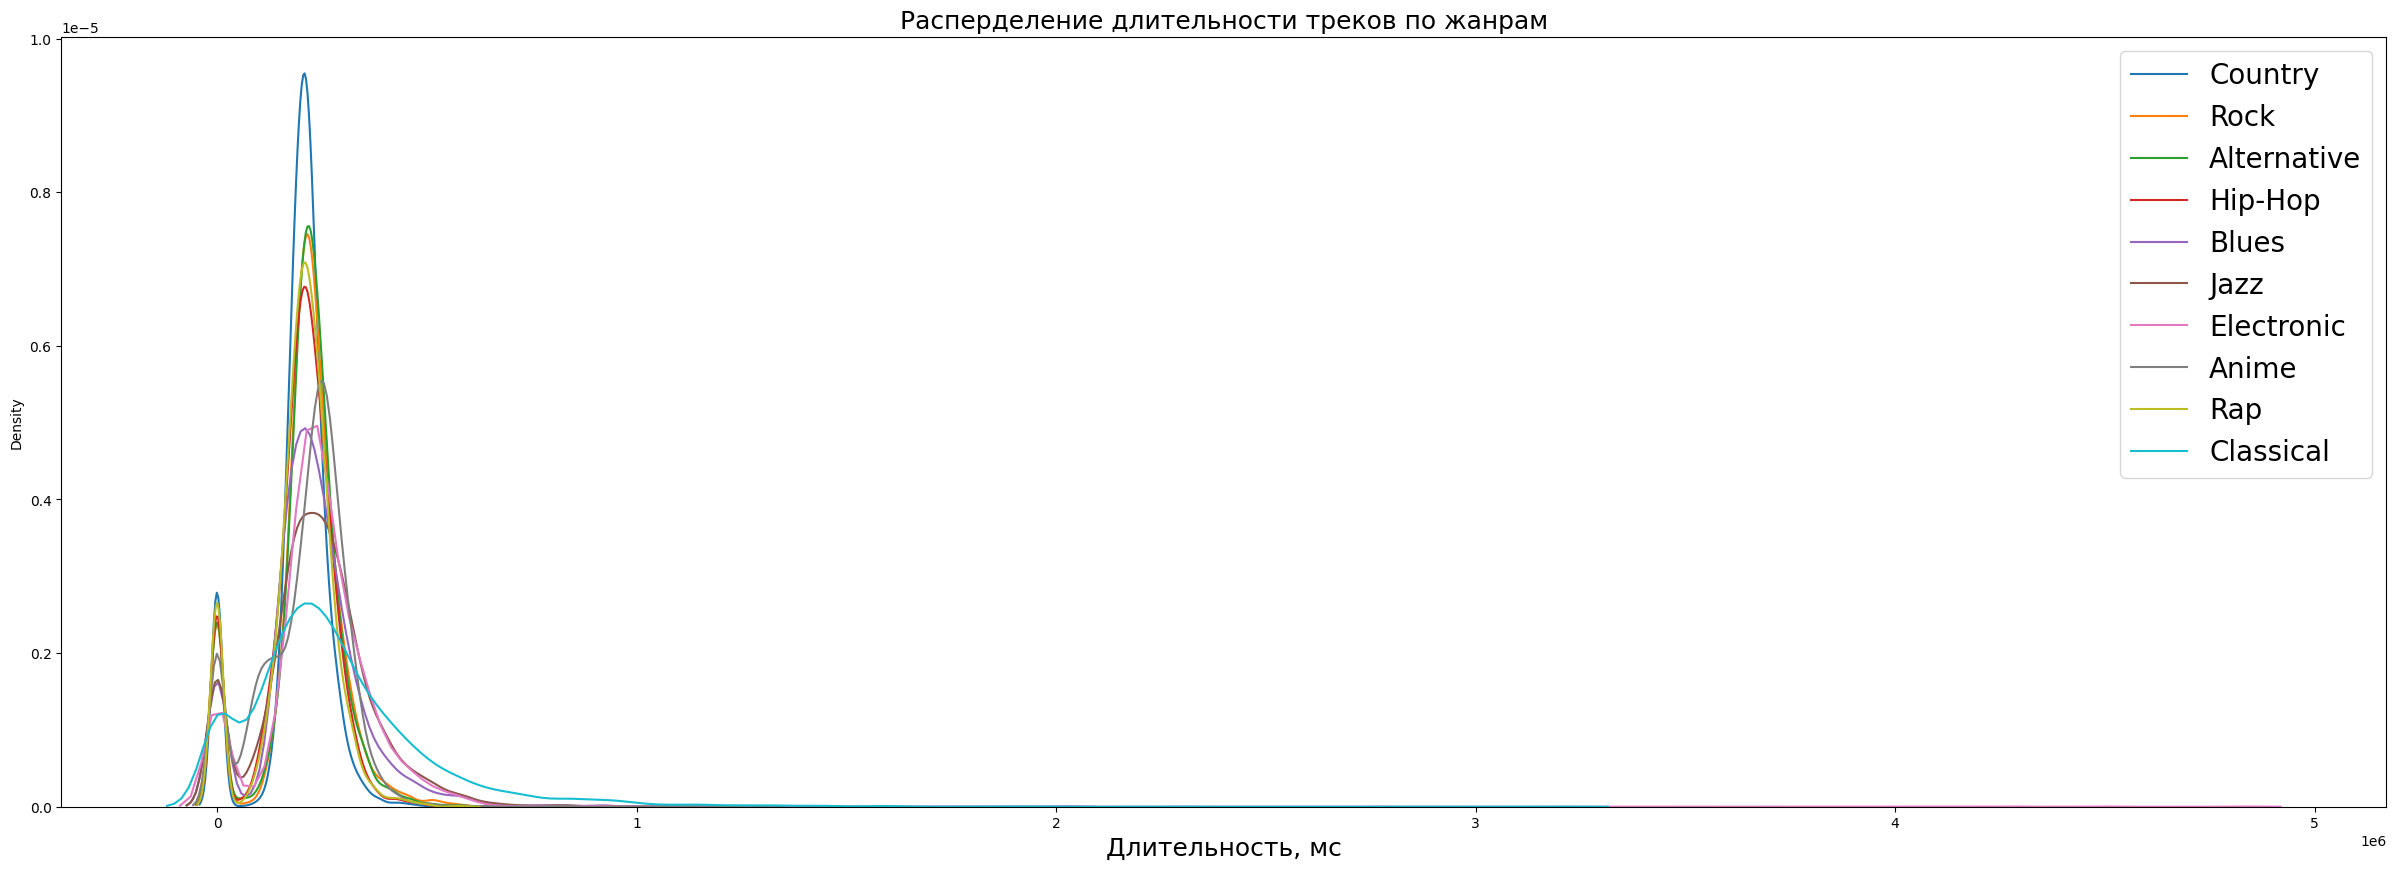

In [231]:
plt.figure(figsize=(30,10))
for genre in train_data['music_genre'].unique():
    sb.kdeplot(data=train_data.loc[train_data['music_genre']==genre, 'duration_ms'], label=genre)

plt.title("Расперделение длительности треков по жанрам", fontsize = 18)

plt.xlabel("Длительность, мс", fontsize = 18)
plt.legend(prop={'size':20});

Видно, что данные имеют аномальные значения. Особенно это видно на максимальной длительности трека. Возьмем ограничения в 2 стандартных отклонения

In [232]:
print((train_data.loc[train_data['duration_ms'] 
                < train_data['duration_ms']
               .std() * 0.95]
               .groupby('music_genre')['tempo']
               .agg({'count'})))

print('Всего треков:', (train_data.loc[train_data['duration_ms'] 
                < train_data['duration_ms']
               .std() * 0.95, 'tempo']
               .count()))

             count
music_genre       
Alternative    592
Anime         1033
Blues          581
Classical      998
Country        523
Electronic     579
Hip-Hop        676
Jazz           744
Rap            691
Rock           568
Всего треков: 6985


Наибольшее количество коротких треков относится к жанрам:
- `Anime`
- `Classical`
- `Jazz`


In [233]:
print((train_data.loc[train_data['duration_ms'] 
                > train_data['duration_ms']
               .std() * 2]
               .groupby('music_genre')['tempo']
               .agg('count')))
print('Всего треков:', (train_data.loc[train_data['duration_ms'] 
                > train_data['duration_ms']
               .std() * 2, 'tempo']
               .count()))

music_genre
Alternative    1254
Anime          1774
Blues          1751
Classical      2351
Country         677
Electronic     2047
Hip-Hop        1065
Jazz           2098
Rap             974
Rock           1302
Name: tempo, dtype: int64
Всего треков: 15293


А наибольшее количество долгих треков относится к жанрам:
- `Jazz`
- `Classical`
- `Electronic`



Отберем только те треки длительность которых укладывается в заданый нами интервал и оценим расспределение длительности треков по жанрам

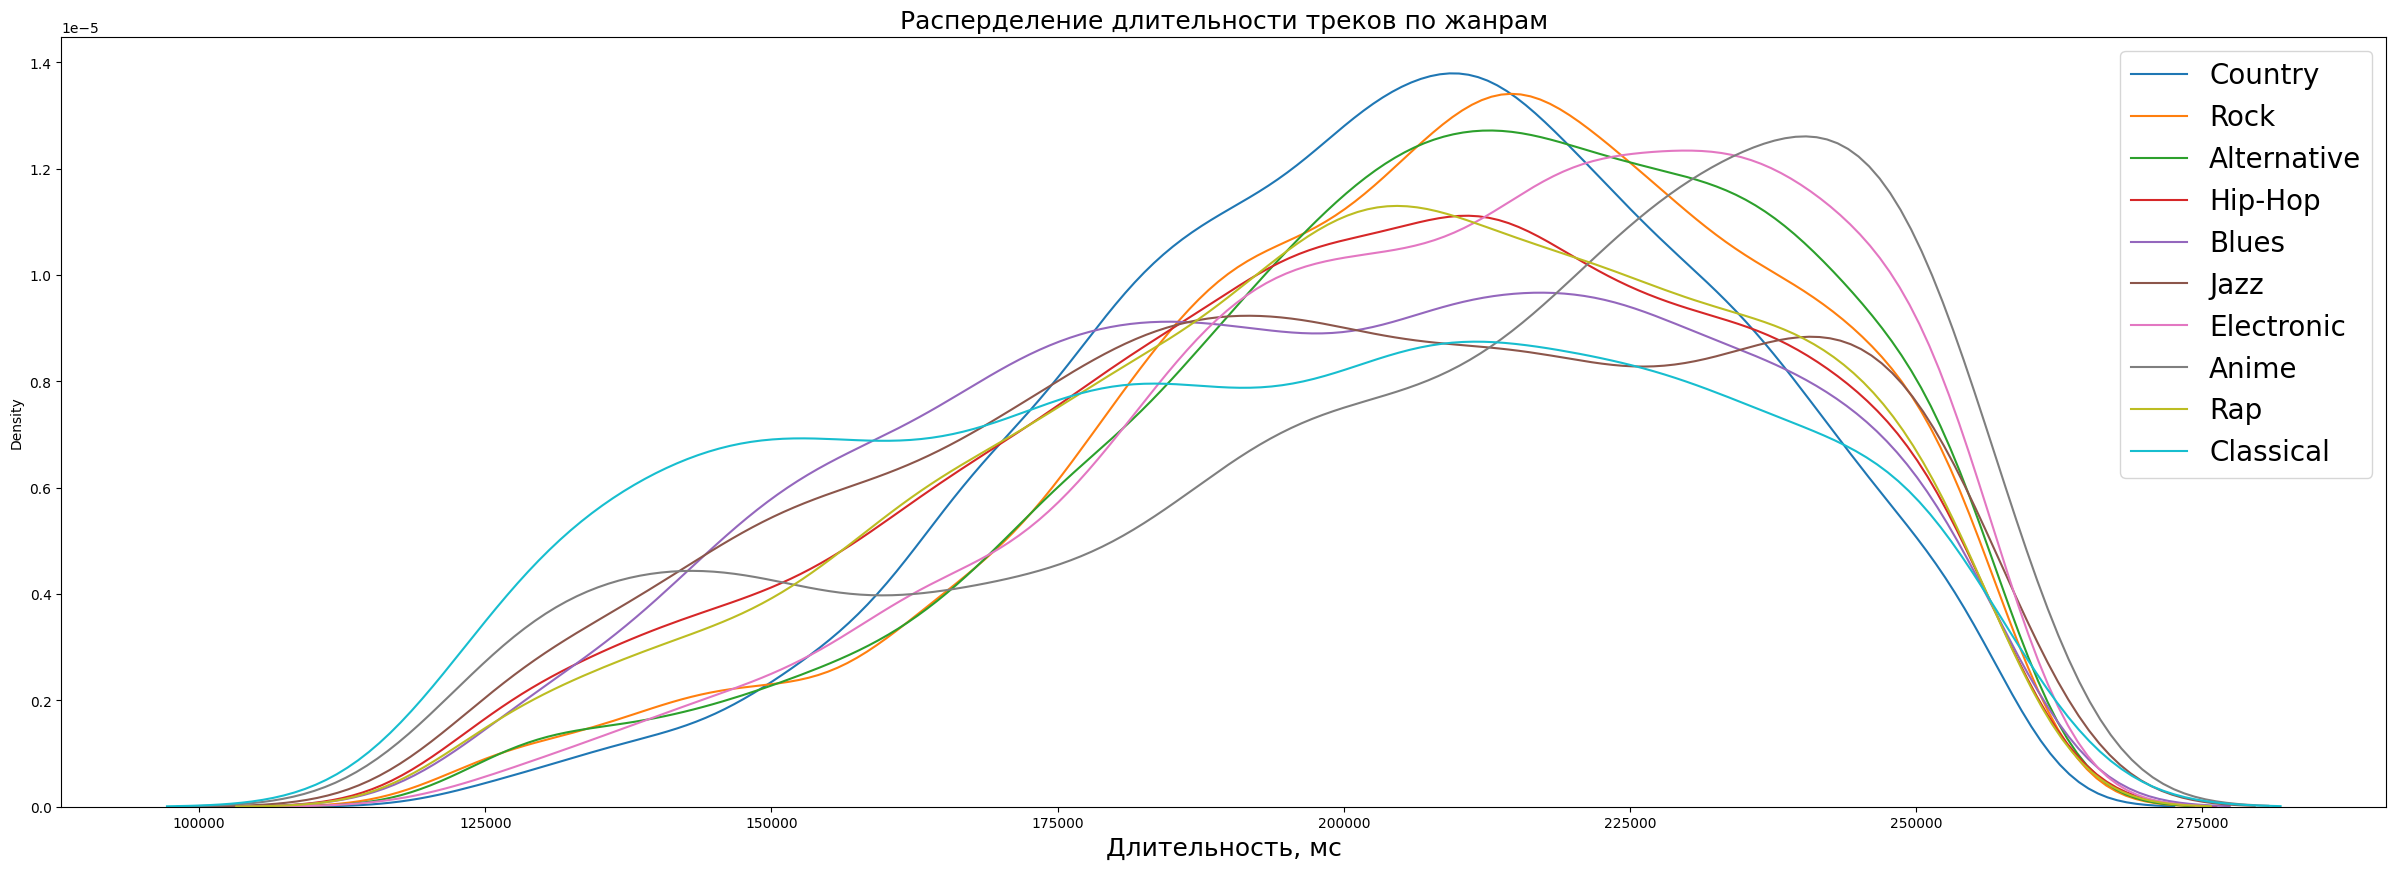

In [234]:
plt.figure(figsize=(30,10))
for genre in train_data['music_genre'].unique():
    sb.kdeplot(data=train_data.loc[(train_data['music_genre']==genre) & 
                                   ((train_data['duration_ms'] > train_data['duration_ms'].std() * 0.95) & 
                                    (train_data['duration_ms'] < train_data['duration_ms'].std() * 2)), 'duration_ms'], label=genre)

plt.title("Расперделение длительности треков по жанрам", fontsize = 18)

plt.xlabel("Длительность, мс", fontsize = 18)
plt.legend(prop={'size':20});

Из графика можно сделать вывод, что выбранная нами классификация достаточно описывает разделение треков на длинные, короткие и средние.

Создадим новый признак `duration_class` который будет являтся идентификатором длительности трека (short: -1, median: 0, long: 1)

In [235]:
def sml_train_songs(row):
    if row < train_data['duration_ms'].std() * 0.95:
        return -1
    elif row > train_data['duration_ms'].std() * 3:
        return 1
    else:
        return 0

In [236]:
def sml_test_songs(row):
    if row < test_data['duration_ms'].std() * 0.95:
        return -1
    elif row > test_data['duration_ms'].std() * 3:
        return 1
    else:
        return 0

In [237]:
train_data['duration_class'] = train_data['duration_ms'].apply(sml_train_songs)

In [238]:
test_data['duration_class'] = test_data['duration_ms'].apply(sml_test_songs)

**Привлекательность**

Рассмотрим корреляцию между параметрами `liveness` - привлекательность и `valence` - привлекательность произведения для пользователей сервиса.


/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_3926/3018716432.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(train_data.corr(), annot=True, cmap=sb.diverging_palette(220, 10, as_cmap=True));


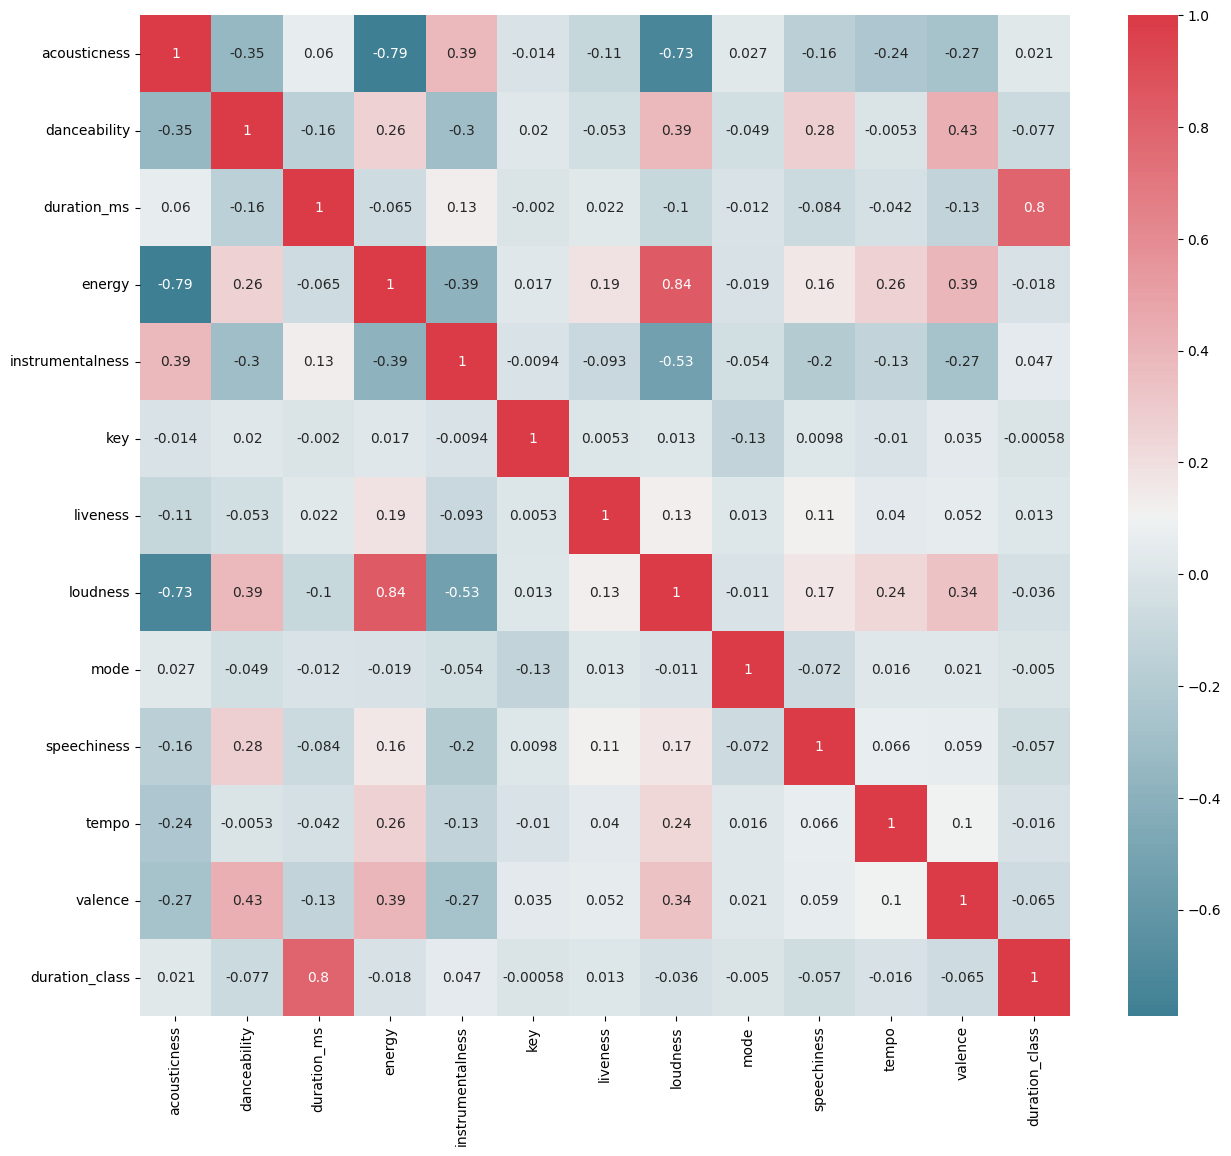

In [239]:
plt.figure(figsize=(15, 13))
sb.heatmap(train_data.corr(), annot=True, cmap=sb.diverging_palette(220, 10, as_cmap=True));

Линейной зависимости от этих двух параметров не наблюдается. Оставим оба этих параметра и выберем наилучший путем рассчета значения вздутия дисперсии.

# Подготовка признаков

Рассмотрим долю жанров в датасете

In [240]:
train_data['music_genre'].value_counts()/len(train_data)

Blues          0.101285
Rap            0.101052
Alternative    0.100820
Rock           0.100548
Electronic     0.100548
Country        0.100200
Anime          0.099773
Classical      0.098843
Hip-Hop        0.098494
Jazz           0.098417
Name: music_genre, dtype: float64

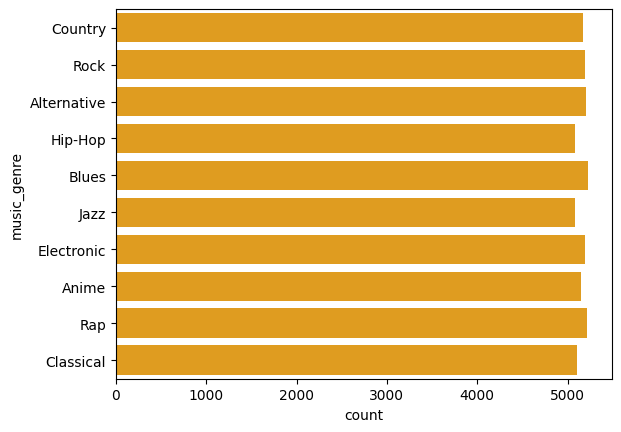

In [245]:
sb.countplot(y="music_genre", data=train_data, color='orange');

Можно сказать, что все жанры имеют равную долю информации в датасете.

Предварительно проверим на пропуски.

In [246]:
train_data.isna().sum()

acousticness        1
danceability        1
duration_ms         1
energy              1
instrumentalness    1
key                 0
liveness            1
loudness            1
mode                0
speechiness         1
tempo               0
valence             1
music_genre         1
duration_class      0
dtype: int64

От одной записи думаю можно избавиться.

In [247]:
train_data = train_data.dropna()

## Исследование мультиколлениарности

Перед исследованием мультиколлениарности признаков перемешаем наш набор данных и разобьем данные.

In [249]:
train_data = train_data.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

In [250]:
features = train_data.drop(['music_genre'], axis = 1)
target = train_data['music_genre']

features_test = test_data
target_test = submit_test['music_genre']

Мультиколлениарность - это наличие линейной зависимости между регрессорами. Посмотрим на ковариационную матрицу наших признаков.

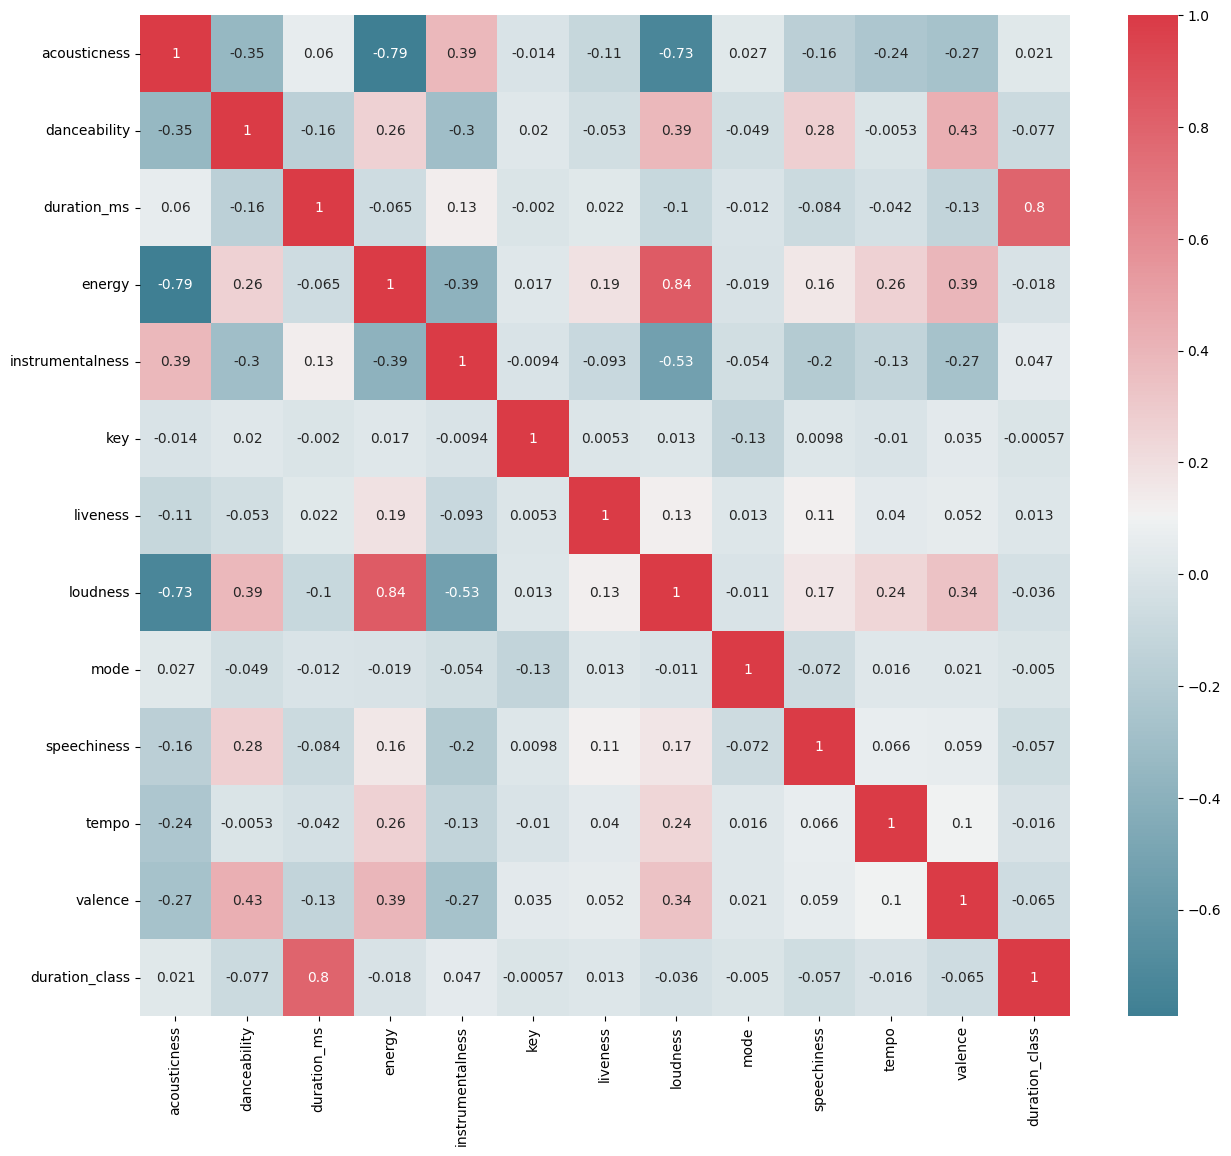

In [308]:
plt.figure(figsize=(15, 13))
sb.heatmap(features.corr(), annot=True, cmap=sb.diverging_palette(220, 10, as_cmap=True));

Обратим внимание что некоторые признаки имеют высокую степень кореляции Пирсона. Пирсон — отличный выбор, когда у есть непрерывные данные для пары переменных, а взаимосвязи следуют прямой линии. Но, пришло время найти другую меру корреляции!

Корреляция Спирмена в статистике является непараметрической альтернативой корреляциям Пирсона. Корреляцию Спирмена используется для данных, которые следуют криволинейным, монотонным отношениям, а также для порядковых данных.

А также вычислим коэффициент вздутия дисперсии (VIF)

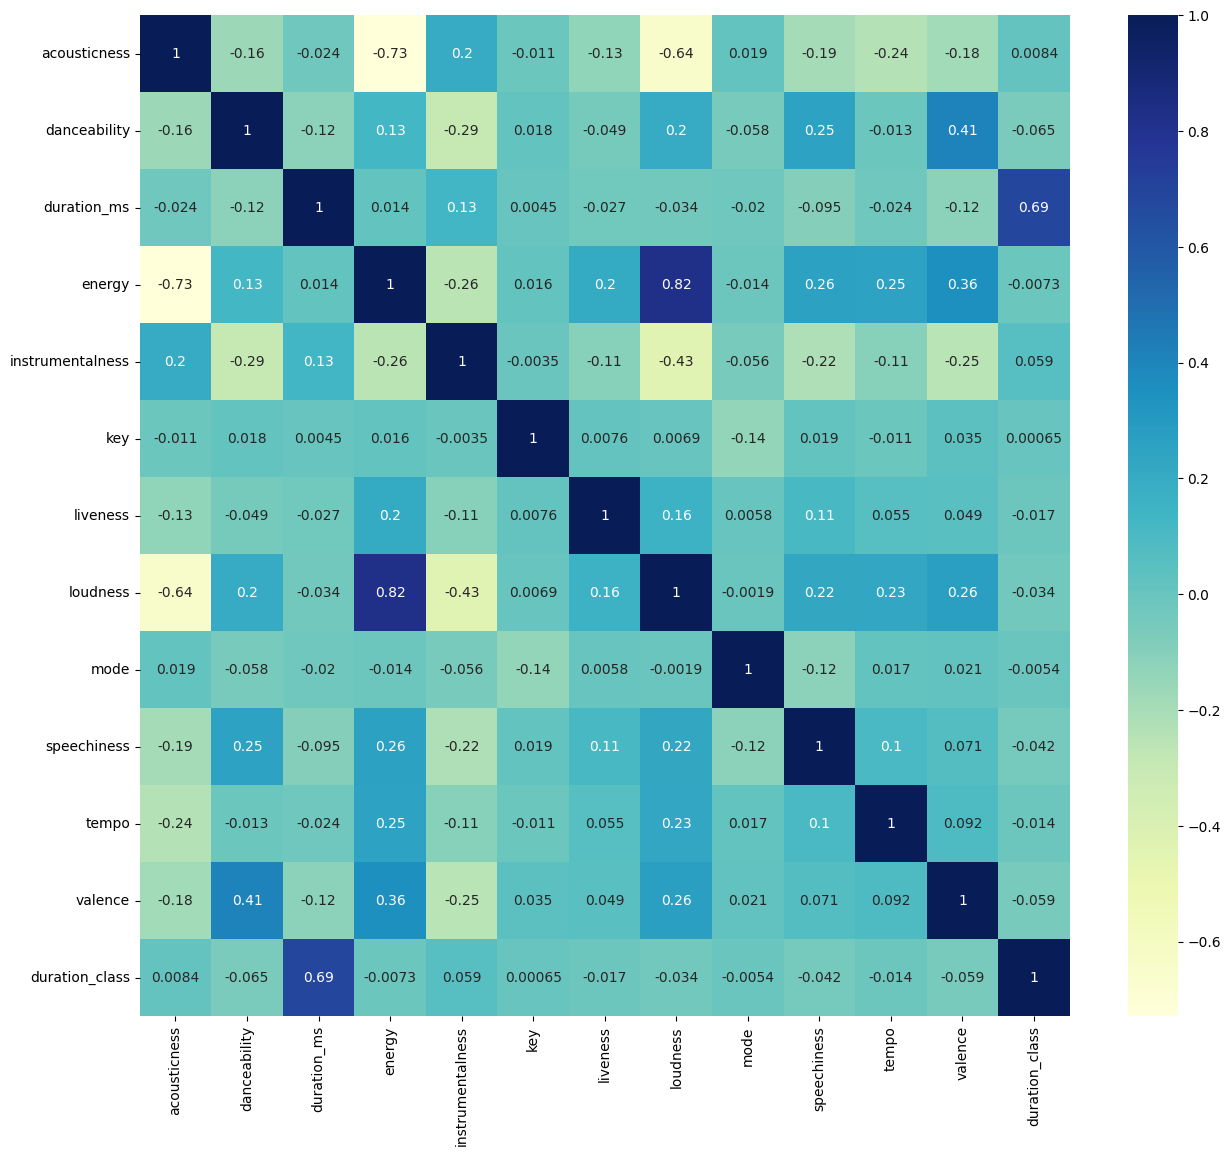

In [309]:
plt.figure(figsize=(15, 13))
sb.heatmap(features.corr(method='spearman'), cmap="YlGnBu", annot=True);


Обратим внимание на то как изменились значения корреляции которые мы наблюдали при установлении корреляции Пирсона. Не сильно, но другая картина.

In [253]:
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns

# вычисление VIF для каждого признака
vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                          for i in range(len(features.columns))]
  
print(vif_data)

             feature        VIF
0       acousticness   4.449948
1       danceability  12.065536
2        duration_ms  10.250248
3             energy  17.112296
4   instrumentalness   1.943091
5                key   3.566955
6           liveness   2.595498
7           loudness   9.043983
8               mode   2.567802
9        speechiness   2.128248
10             tempo  16.086863
11           valence   6.426749
12    duration_class   2.688541


Видно как параметры темп, энергия и танцевальность `вздуты`

In [254]:
vif_data = pd.DataFrame()
vif_data["feature"] = features.drop(['tempo','energy','danceability'], axis=1).columns

vif_data["VIF"] = [variance_inflation_factor(features.drop(['tempo','energy','danceability'], axis=1).values, i)
                          for i in range(len(features.drop(['tempo','energy','danceability'], axis=1).columns))]
  
print(vif_data)

            feature       VIF
0      acousticness  3.882718
1       duration_ms  7.051726
2  instrumentalness  1.902572
3               key  3.262603
4          liveness  2.395483
5          loudness  7.620892
6              mode  2.408006
7       speechiness  1.864888
8           valence  3.785896
9    duration_class  2.160326


In [256]:
vif_data = pd.DataFrame()
vif_data["feature"] = features_test.drop(['instance_id', 'track_name','obtained_date'], axis=1).columns

vif_data["VIF"] = [variance_inflation_factor(features_test.drop(['instance_id', 'track_name','obtained_date'], axis=1).values, i)
                          for i in range(len(features_test.drop(['instance_id', 'track_name','obtained_date'], axis=1).columns))]
  
print(vif_data)

             feature        VIF
0       acousticness   3.883929
1       danceability  12.386371
2        duration_ms  14.313608
3             energy  17.011336
4   instrumentalness   1.814827
5                key   3.411430
6           liveness   2.559223
7           loudness   8.765799
8               mode   2.212244
9        speechiness   2.099045
10             tempo  11.664385
11           valence   6.494542
12    duration_class   3.278774


Существует негласное правило что если VIF больше 10, то это флаг о том что эти регрессоры проявляют мультиколлениарность

In [257]:
features_test = features_test.drop(['instance_id', 'track_name','obtained_date'], axis=1)

Сформируем тренировочные и валидационные выборки.

In [258]:
features_train, features_valid, target_train, target_valid = \
    train_test_split(features, target, train_size=0.75, random_state=RANDOM_STATE, stratify=target)

In [259]:
print(f"В тренировочной выборке {features.shape[0]} записей из которых {len(features_train)} = {round(features_train.shape[0]/len(train_data)*100)}%")
print(f"Записей из тренировочной в валидационной выборке {features_valid.shape[0]} = {round(features_valid.shape[0]/len(train_data)*100)}%")

В тренировочной выборке 51606 записей из которых 38704 = 75%
Записей из тренировочной в валидационной выборке 12902 = 25%


In [260]:
target_train.value_counts().sort_index()

Alternative    3902
Anime          3862
Blues          3920
Classical      3826
Country        3878
Electronic     3892
Hip-Hop        3812
Jazz           3809
Rap            3911
Rock           3892
Name: music_genre, dtype: int64

## Baseline

### Модели

Для базовых моделей будем использовать `LogisticRegression` и `RandomForestClassifier`, эти модели выбраны для обзора распределения признаков. Основной моделью будет модель градиентного бустинга `CatBoost`, как одна из лучших моделей для решения задачи мультиклассификации. 

### Метрики

Качество обучения моделей будет оцениваться по метрике `F (F beta)`

**F (F beta)**

В задаче мультиклассификации мы будем отдавать большее предпочтение точности нашего решения. Для этого отлично подойдет метрика F beta, где beta это некий параметр перебалансировки веса между precision и recall. Если значение beta < 1 то значение метрики будет больше направленно к Precision, а если больше то к Recall. 


Формула для метрики F beta ниже

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mi>F</mi>
    <mi>&#x3B2;</mi>
  </msub>
  <mo>=</mo>
  <mo stretchy="false">(</mo>
  <mn>1</mn>
  <mo>+</mo>
  <msup>
    <mi>&#x3B2;</mi>
    <mn>2</mn>
  </msup>
  <mo stretchy="false">)</mo>
  <mfrac>
    <mrow>
      <mtext>precision</mtext>
      <mo>&#xD7;</mo>
      <mtext>recall</mtext>
    </mrow>
    <mrow>
      <msup>
        <mi>&#x3B2;</mi>
        <mn>2</mn>
      </msup>
      <mtext>precision</mtext>
      <mo>+</mo>
      <mtext>recall</mtext>
    </mrow>
  </mfrac>
  <mo>.</mo>
</math>

In [267]:
%%time
lr_model = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=200, class_weight='balanced')

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 7.87 µs


In [302]:
lr_model.fit(features_train, target_train)

LogisticRegression(class_weight='balanced', max_iter=200,
                   multi_class='multinomial')

In [303]:
lr_pred = lr_model.predict(features_valid)

In [304]:
fbeta_score(target_valid,lr_model.predict(features_valid),average='macro',beta=0.5)

0.058316100416649364

Результатом обучения логистической регрессии стало значение Fb = 0.05. Попробуем обучить Случайный лес.

In [305]:
rfc_model = RandomForestClassifier(n_estimators=100,max_depth=35,min_samples_leaf = 2, random_state=RANDOM_STATE, class_weight='balanced')
rfc_model.fit(features_train, target_train)

RandomForestClassifier(class_weight='balanced', max_depth=35,
                       min_samples_leaf=2, random_state=1220)

In [306]:
y_rfc = rfc_model.predict(features_valid)

In [307]:
fbeta_score(target_valid,rfc_model.predict(features_valid),average='macro',beta=0.5)

0.46116106964761505

Уже лучше. Воспользуемся моделью случайного леса для определения приоритетности признаков в этой модели.

In [272]:
selector = RFE(rfc_model, n_features_to_select=1)
selector.fit(features_train, target_train)

RFE(estimator=RandomForestClassifier(class_weight='balanced', max_depth=35,
                                     min_samples_leaf=2, random_state=1220),
    n_features_to_select=1)

In [273]:
print(f"Важность признака в модели")
for i in range(len(selector.ranking_)):
    print(f"#{i+1}: {features_train.columns[selector.ranking_[i]-1]} ")

Важность признака в модели
#1: duration_ms 
#2: instrumentalness 
#3: mode 
#4: liveness 
#5: key 
#6: tempo 
#7: speechiness 
#8: danceability 
#9: valence 
#10: energy 
#11: acousticness 
#12: loudness 
#13: duration_class 


Обратим внимание на то, что самый значимый признак для модели это длительность трека в мс, перед обучением мы синтезировали новый признак, который должен однозначено говорить о длительности модели, но как мы видим он вносит наименьший вклад в обучение. Возьмем во внимание значение важности признаков на базовых моделях, а также значения VIF.

## Подготовка к градиентному бустингу

Перед началом обучения модели градиентного бустинга необходимо увеличить массив данных до размеров характерных такого род моделей. 


Для увеличения выборки воспользуемся нашим исходным массивом в котором порядка 50 тысяч записей и просемплируем по каждому жанру наши признаки добавив в новый массив данных. 
Напишим функцию для добавления новой случайной выборки элементов с оси объекта, используюя random_state для воспроизводимости.

In [274]:
def rebalance(data):
    max_val = 100000
    _data = pd.DataFrame(columns=data.columns)
    
    for genre in data['music_genre'].unique():
        _data = _data.append(data[data['music_genre'] == genre].sample(n=max_val, random_state=RANDOM_STATE, replace=True), ignore_index=True, sort=False)  
    return _data

Выполним перебалансировку данных из исходного массива, убрав такие признаки как: `loudness`, `danceability`, `acousticness`, `valence`, `energy` и `duration_ms` исходя из параметров корреляции и VIF.

In [288]:
balanced_df = rebalance(train_data)
balanced_df['mode'].replace(mode_dict, inplace=True)
balanced_df['key'] = balanced_df['key'].replace(key_dict).astype(int)
features_trainB, features_validB, target_trainB, target_validB = train_test_split(balanced_df.drop(columns='music_genre'),
                                                                                  balanced_df['music_genre'], test_size=0.25, random_state=RANDOM_STATE,
                                                                                  shuffle=balanced_df['music_genre'])

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_3926/2794522315.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _data = _data.append(data[data['music_genre'] == genre].sample(n=max_val, random_state=RANDOM_STATE, replace=True), ignore_index=True, sort=False)


In [289]:
features_trainB = features_trainB.drop(['loudness', 'danceability', 'acousticness', 'valence', 'energy', 'duration_ms'],axis=1)
features_validB = features_validB.drop(['loudness', 'danceability', 'acousticness', 'valence', 'energy', 'duration_ms'],axis=1)

CatBoost — это открытая программная библиотека, разработанная компанией Яндекс и реализующая уникальный патентованный алгоритм построения моделей машинного обучения, использующий одну из оригинальных схем градиентного бустинга.

В данной задачи функцией потерь является `MultiClass`, количество итераций 10000, а шаг обучения 0.1

In [ ]:
cat_model = CatBoostClassifier(loss_function='MultiClass',
                                      iterations=10000,
                                      depth=10,
                                      learning_rate=0.1,
                                      random_state=RANDOM_STATE,
                                      early_stopping_rounds = 200,
                                      task_type="GPU"
                                      ).fit(features_trainB, 
                                        target_trainB,
                                        eval_set=(features_validB, target_validB),
                                        verbose=False,plot=True)
# cat_model.save_model('test_model')

In [277]:
# cat_model = CatBoostClassifier()
# cat_model.load_model('./App/CatModel.dump')

Рассчитаем наше значение F beta

In [279]:
fbeta_score(target_validB,cat_model.predict(features_validB),average='macro',beta=0.5)

0.9443479803543857

После обучения мы имеем значение 0.94. Выполним запись наших предсказанных значений в csv файл для отправки на Kaggle.

In [280]:
pred_cat = cat_model.predict_proba(features_test)
pred_cat[0]

array([9.92530418e-01, 6.77283734e-09, 9.70273462e-10, 2.07451910e-08,
       1.65916288e-08, 8.61490811e-06, 2.89566224e-03, 1.26366368e-06,
       4.56399577e-03, 7.28804227e-10])

In [281]:
pred_cat = cat_model.predict(features_test)

In [282]:
submission = pd.DataFrame({
    'instance_id': submit_test['instance_id'],
    'music_genre': pred_cat.ravel()
})
submission.to_csv('submission.csv', index=False)
submission

,instance_id,music_genre
0,48564,Alternative
1,72394,Alternative
2,88081,Rap
3,78331,Country
4,72636,Jazz
...,...,...
5094,50532,Country
5095,26255,Hip-Hop
5096,67924,Country
5097,79778,Electronic


# Вывод

**Цель исследования**

Разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

**Задачи:**

- загрузка и ознакомление с данными;
- предварительная обработка;
- EDA;
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков.

**Подготовка данных**

Выполнено преобразование типов данных, синтезирован новый признак который использовался в моделе `duration_class`, а также произведено явное преобразование данных. Выявлены явные и неявные дубликаты, выполнен анализ аномальных значений в данных.


**Мультиколлениарность**

Выполнено исследование исходных данных на наличие мультиколлениарности среди имеющихся регрессоров. Найденые регрессоры по средством оценки вздутия дисперсии и значений корреляций Пирсона и Спирмана, которые в последствие не вошли в обучающую выборку (`loudness`, `danceability`, `acousticness`, `valence` `energy` и `duration_ms`)


**Выбор модели**

Для базовых моделей использовались `LogisticRegression` и `RandomForestClassifier`, эти модели выбраны для обзора распределения признаков. Основной моделью была модель градиентного бустинга `CatBoost`, как одна из лучших моделей для решения задачи мультиклассификации. 

**Метрика**

**F (F beta)**

В данной задаче была выбрана метрика F beta, так как она лучше всего подходит для оценки качества модели при решении задачи мультиклассификации.


Формула для метрики F beta ниже

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mi>F</mi>
    <mi>&#x3B2;</mi>
  </msub>
  <mo>=</mo>
  <mo stretchy="false">(</mo>
  <mn>1</mn>
  <mo>+</mo>
  <msup>
    <mi>&#x3B2;</mi>
    <mn>2</mn>
  </msup>
  <mo stretchy="false">)</mo>
  <mfrac>
    <mrow>
      <mtext>precision</mtext>
      <mo>&#xD7;</mo>
      <mtext>recall</mtext>
    </mrow>
    <mrow>
      <msup>
        <mi>&#x3B2;</mi>
        <mn>2</mn>
      </msup>
      <mtext>precision</mtext>
      <mo>+</mo>
      <mtext>recall</mtext>
    </mrow>
  </mfrac>
  <mo>.</mo>
</math>


**Обучение моделей**

Показатели метрик для валидационной выборки:
- `LogisticRegression`
    - F-beta 0.05
- `RandomForestClassifier`
    - F-beta 0.46
- `CatBoostClassifier`
    - F-beta 0.94
